In [199]:
import os
import re
import torch
import pickle
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [200]:
DATA_DIR = Path("../data/k0/discontinuities")

In [201]:
labels = pickle.load(open("../data/k0/sentiment-analysis/labels.pkl", "rb"))
# convert all of the labels to ints 
labels = [int(v) for v in labels]

In [202]:
MODELS = [
    "bert-large-uncased-imdb",
    "bert-base-uncased-imdb",
    "roberta-base-imdb",
    "roberta-large-imdb",
    "gpt2-imdb",
    "t5-base-imdb",
    "t5-small-imdb"
]

In [203]:
delta = 0.3
epsilon = 0.3
layer = 5

X = []

# for the given delta value, epsilon value, and layer, read the discontinuities
for m in MODELS:
    file_name = DATA_DIR / f"{m}/L{layer - 1}.pth"
    disconts = torch.load(file_name)
    
    # file format for disconts is: 
    # 1000 rows, for each value of delta
    # 15000 columns, one for each data point
    # each item is the min value of epsilon for which it will be a discontinuity
    
    row_idx = int(delta * 1000)
    
    ret = []
    
    row = disconts[row_idx].detach().cpu().numpy()
    
    ret = np.where(row > epsilon, 1, 0)
    
    X.append(ret)

X = np.asarray(X)

In [155]:
x = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

np.where(x > 0.7, 1, 0)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [156]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(X)

In [157]:
seed = 42

mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
    #normalized_stress="auto",
)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
    #normalized_stress=True
)
npos = nmds.fit_transform(similarities, init=pos)

In [158]:
# Rescale the data
pos *= np.sqrt((X**2).sum()) / np.sqrt((pos**2).sum())
npos *= np.sqrt((X**2).sum()) / np.sqrt((npos**2).sum())

In [159]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

4.693435914968256e-08


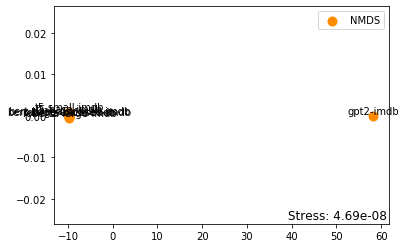

In [166]:
clf = PCA(n_components=2)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

#npos = scaler.fit_transform(npos)

fig, ax = plt.subplots()

#ax.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
ax.scatter(npos[:, 0], npos[:, 1], color="darkorange", s=s, lw=0, label="NMDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

"""
# Add annotations for data points without overlapping
spacing = 0.03  # Adjust this value to control the spacing between annotations
for i, txt in enumerate(MODELS):
    x, y = npos[i][0], npos[i][1]
    for other_i, other_txt in enumerate(MODELS):
        if i != other_i:
            other_x, other_y = npos[other_i][0], npos[other_i][1]
            if abs(x - other_x) < spacing and abs(y - other_y) < spacing:
                if x < other_x:
                    x -= spacing
                else:
                    x += spacing
                if y < other_y:
                    y -= spacing
                else:
                    y += spacing
    ax.annotate(txt, (x, y))
"""

# Adding labels to data points
for i, txt in enumerate(MODELS):
    ax.text(npos[i][0], npos[i][1], f"{txt}", fontsize=10, ha='center', va='bottom')

# If you want to calculate the normalized stress:
normalized_stress = np.sqrt(nmds.stress_) / np.sqrt(np.sum(similarities**2))

print(normalized_stress)

ax.text(0.7, 0.02, f'Stress: {normalized_stress:.2e}', transform=ax.transAxes, fontsize=12)

plt.savefig('nmds.pdf')

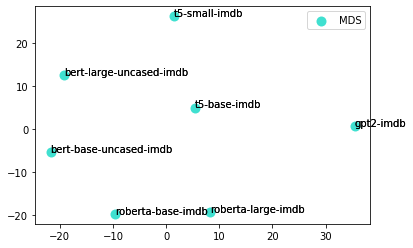

In [167]:
clf = PCA(n_components=2)

pos = clf.fit_transform(pos)

#pos = scaler.fit_transform(pos)

fig, ax = plt.subplots()

ax.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

for i, txt in enumerate(MODELS):
    ax.annotate(txt, (pos[i][0], pos[i][1]))

# Add annotations for data points without overlapping
spacing = 0.03  # Adjust this value to control the spacing between annotations
for i, txt in enumerate(MODELS):
    x, y = pos[i][0], pos[i][1]
    for other_i, other_txt in enumerate(MODELS):
        if i != other_i:
            other_x, other_y = pos[other_i][0], pos[other_i][1]
            if abs(x - other_x) < spacing and abs(y - other_y) < spacing:
                if x < other_x:
                    x -= spacing
                else:
                    x += spacing
                if y < other_y:
                    y -= spacing
                else:
                    y += spacing
    ax.annotate(txt, (x, y))

plt.savefig('mds.pdf')

### Calculate K0 vulnerability

In [168]:
import os

def get_num_files_in_dir(directory_path):
    number_of_files = sum(1 for entry in os.scandir(directory_path) if entry.is_file())

    return number_of_files

In [169]:
delta = 0.3
epsilon = 0.3

vulnerability_scores = []

# for the given delta value, epsilon value, and layer, read the discontinuities
for m in MODELS:
    num_layers = get_num_files_in_dir(DATA_DIR / f"{m}/")
    vulnerability_score = 0
    
    for i in range(num_layers):
        file_name = DATA_DIR / f"{m}/L{i}.pth"
        disconts = torch.load(file_name)

        # file format for disconts is: 
        # 1000 rows, for each value of delta
        # 15000 columns, one for each data point
        # each item is the min value of epsilon for which it will be a discontinuity

        numpy_arrays = [tensor.cpu().numpy().flatten() for tensor in disconts]
        
        matrix = np.asarray(numpy_arrays)
        
        matrix = np.log1p(matrix)

        vulnerability_score = np.sum(matrix)
    
    # account for different number of layers by averaging across each layer
    # should different layers get different weights???
    
    vulnerability_score /= num_layers
        
    vulnerability_scores.append((m, vulnerability_score))

vulnerability_scores

[('bert-large-uncased-imdb', 21279.12),
 ('bert-base-uncased-imdb', 63816.51442307692),
 ('roberta-base-imdb', 36815.55528846154),
 ('roberta-large-imdb', 20260.1875),
 ('gpt2-imdb', 60935.754807692305),
 ('t5-base-imdb', 32532.814903846152),
 ('t5-small-imdb', 70240.11607142857)]

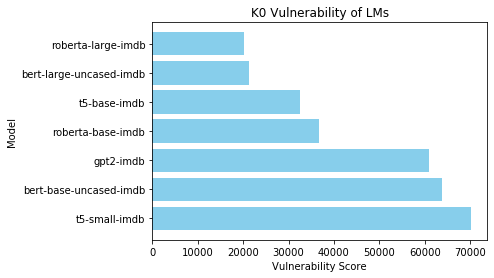

In [170]:
# Sort the data in descending order
sorted_data = sorted(vulnerability_scores, key=lambda x: x[1], reverse=True)
categories, values = zip(*sorted_data)

# Create a bar chart
plt.barh(categories, values, color='skyblue')

# Add labels and a title
plt.xlabel('Vulnerability Score')
plt.ylabel('Model')
plt.title('K0 Vulnerability of LMs')

# Show the plot
plt.show()


### adversarial vulnerability

In [171]:
import pandas as pd

models = [
    "bert-large-uncased",
    "bert-base-uncased",
    "roberta-base",
    "roberta-large",
    "gpt2",
    "t5-base",
    "t5-small"
]

actual_vulnerability = []

for m in models:
    csv_file = f'../data/adversarial-attacks/tf-{m}.csv'

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    num_success = (df['result_type'] == "Successful").sum()
    
    actual_vulnerability.append((m, num_success))


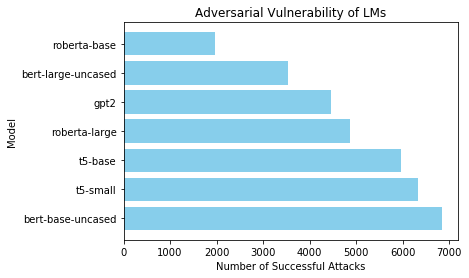

In [172]:
import matplotlib.pyplot as plt

# Sort the data in descending order
sorted_data = sorted(actual_vulnerability, key=lambda x: x[1], reverse=True)
categories, values = zip(*sorted_data)

# Create a bar chart
plt.barh(categories, values, color='skyblue')

# Add labels and a title
plt.xlabel('Number of Successful Attacks')
plt.ylabel('Model')
plt.title('Adversarial Vulnerability of LMs')

# Show the plot
plt.show()


In [176]:
vulnerability_scores

[('bert-large-uncased-imdb', 21279.12),
 ('bert-base-uncased-imdb', 63816.51442307692),
 ('roberta-base-imdb', 36815.55528846154),
 ('roberta-large-imdb', 20260.1875),
 ('gpt2-imdb', 60935.754807692305),
 ('t5-base-imdb', 32532.814903846152),
 ('t5-small-imdb', 70240.11607142857)]

In [177]:
actual_vulnerability

[('bert-large-uncased', 3528),
 ('bert-base-uncased', 6855),
 ('roberta-base', 1958),
 ('roberta-large', 4867),
 ('gpt2', 4467),
 ('t5-base', 5975),
 ('t5-small', 6331)]

No handles with labels found to put in legend.


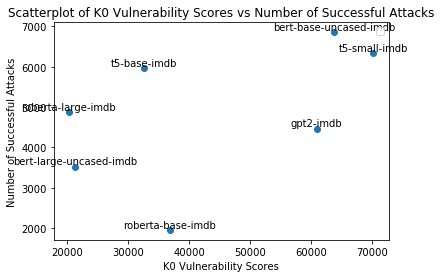

In [194]:
# Create the scatterplot
plt.scatter([value for _, value in vulnerability_scores], [value for _, value in actual_vulnerability], marker='o')

# Customize the plot
plt.title('Scatterplot of K0 Vulnerability Scores vs Number of Successful Attacks')
plt.xlabel('K0 Vulnerability Scores')
plt.ylabel('Number of Successful Attacks')
#plt.grid(True)
plt.legend()

# Adding labels to data points
for i, txt in enumerate(MODELS):
    plt.text(vulnerability_scores[i][1], actual_vulnerability[i][1], f"{txt}", fontsize=10, ha='center', va='bottom')

plt.savefig('k0vuln_vs_attack.pdf')

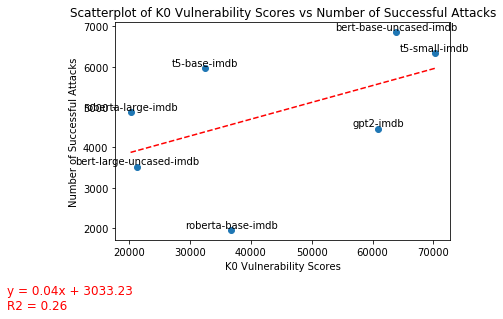

In [298]:
from scipy import stats

# Create the scatterplot
x = np.asarray([value for _, value in vulnerability_scores])
y = np.asarray([value for _, value in actual_vulnerability])
plt.scatter(x, y, marker='o')

# Customize the plot
plt.title('Scatterplot of K0 Vulnerability Scores vs Number of Successful Attacks')
plt.xlabel('K0 Vulnerability Scores')
plt.ylabel('Number of Successful Attacks')

# Adding labels to data points
for i, txt in enumerate(MODELS):
    plt.text(vulnerability_scores[i][1], actual_vulnerability[i][1], f"{txt}", fontsize=10, ha='center', va='bottom')

# Perform linear regression to get the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Label the line with the equation and R-squared value
equation = f'y = {slope:.2f}x + {intercept:.2f}\nR2 = {r_squared:.2f}'
plt.text(0.5, 3, equation, fontsize=12, color='r')

# Plot the line of best fit
x_line = np.linspace(min(x), max(x))
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='r', linestyle='--')

plt.savefig('k0vuln_vs_attack_with_line.pdf')

In [211]:
delta = 0.3
epsilon = 0.3
layer = 5

X = []

# for the given delta value, epsilon value, and layer, read the discontinuities
for m in MODELS:
    file_name = DATA_DIR / f"{m}/L{layer - 1}.pth"
    disconts = torch.load(file_name)
    
    # file format for disconts is: 
    # 1000 rows, for each value of delta
    # 15000 columns, one for each data point
    # each item is the min value of epsilon for which it will be a discontinuity
    
    row_idx = int(delta * 1000)
    
    ret = []
    
    row = disconts[row_idx].detach().cpu().numpy()
    
    ret = np.where(row > epsilon, 1, 0)
    
    X.append(ret)

X = np.asarray(X)

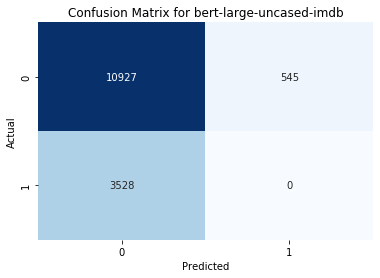

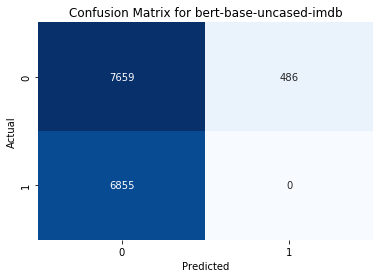

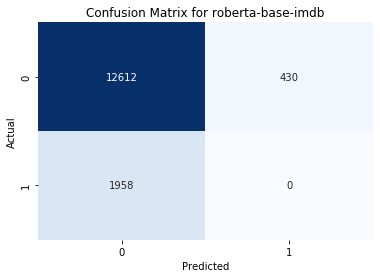

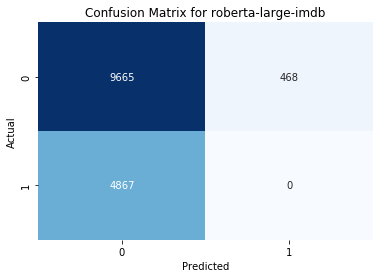

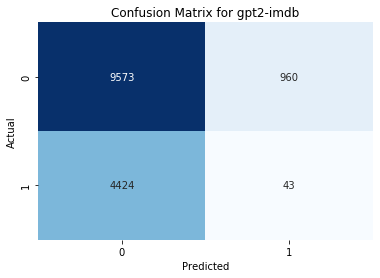

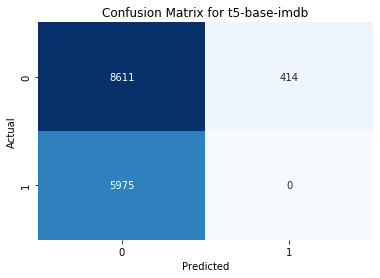

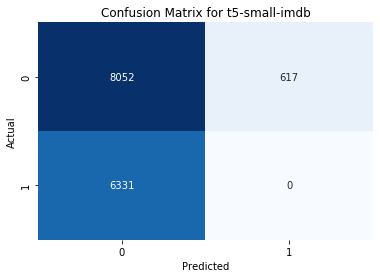

In [212]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

for i in range(len(MODELS)):
    csv_file = f'../data/adversarial-attacks/tf-{models[i]}.csv'

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    actual_arr = (df['result_type'] == "Successful")
    
    conf_matrix = confusion_matrix(actual_arr, X[i])
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {MODELS[i]}')
    plt.show()

## sort vulnerability score by size and stuff

In [227]:
!pip install --upgrade ipywidgets
!pip3 install tqdm==4.40.0

Requirement already up-to-date: ipywidgets in /home/kenneth/.local/lib/python3.8/site-packages (8.1.1)
     |████████████████████████████████| 54 kB 3.9 MB/s eta 0:00:011
ERROR: huggingface-hub 0.17.1 has requirement tqdm>=4.42.1, but you'll have tqdm 4.40.0 which is incompatible.
ERROR: evaluate 0.4.0 has requirement tqdm>=4.62.1, but you'll have tqdm 4.40.0 which is incompatible.
ERROR: datasets 2.14.5 has requirement tqdm>=4.62.1, but you'll have tqdm 4.40.0 which is incompatible.
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [230]:
models = {}

from contextlib import redirect_stdout

for m in MODELS:
    if m.endswith('-imdb'):
        m = m[:-5]
    
    models[m] = AutoModelForSequenceClassification.from_pretrained(m)

AttributeError: 'FloatProgress' object has no attribute 'style'

In [235]:
sizes = {'bert-large-uncased': 335143938, 'bert-base-uncased': 109483778, 'roberta-base': 124647170, 'roberta-large': 355361794, 'gpt2': 124441344, 't5-base': 223495682, 't5-small': 60770306}

def get_size(name):
    if name.endswith('-imdb'):
        name = name[:-5]
    
    return sizes[name]

[('t5-small-imdb', 70240.11607142857), ('bert-base-uncased-imdb', 63816.51442307692), ('gpt2-imdb', 60935.754807692305), ('roberta-base-imdb', 36815.55528846154), ('t5-base-imdb', 32532.814903846152), ('bert-large-uncased-imdb', 21279.12), ('roberta-large-imdb', 20260.1875)]


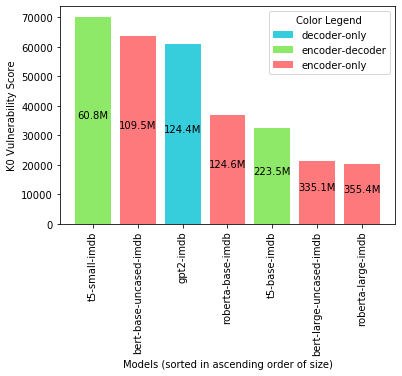

In [262]:
from matplotlib.patches import Patch

# Sort the zipped data based on the third variable
sorted_data = sorted(vulnerability_scores, key=lambda x: sizes[x[0][:-5]])

#{'bert-large-uncased': 335143938, 'bert-base-uncased': 109483778, 
# 'roberta-base': 124647170, 'roberta-large': 355361794, 'gpt2': 124441344, 
# 't5-base': 223495682, 't5-small': 60770306}

sorted_x_values = []
sorted_bar_heights = []

for i in sorted_data:
    sorted_x_values.append(i[0])
    sorted_bar_heights.append(i[1])

print(sorted_data)

bar_colors = ['#8FE968', '#FE797B', '#36CEDC', '#FE797B', '#8FE968', '#FE797B', '#FE797B']
meaning = {
    '#8FE968': 'encoder-decoder',
    '#FE797B': 'encoder-only',
    '#36CEDC': 'decoder-only'
}

# Create the bar chart
bars = plt.bar(sorted_x_values, sorted_bar_heights, color=bar_colors)

# Label the axes
plt.xlabel('Models (sorted in ascending order of size)')
plt.ylabel('K0 Vulnerability Score')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Create a list of proxy artists for the legend
legend_elements = [Patch(facecolor=color, label=meaning[color]) for color in np.unique(bar_colors)]

# Create a legend with proxy artists
plt.legend(handles=legend_elements, title='Color Legend', loc='upper right')

# Add labels on top of each bar
for x, y in zip(sorted_x_values, sorted_bar_heights):
    plt.text(x, y / 2, f'{get_size(x) / 1e6:.1f}M', ha='center', va='bottom')

# Show the plot
plt.savefig('k0_by_size.pdf')

#### scatterplot of size vs k0 vulnerability

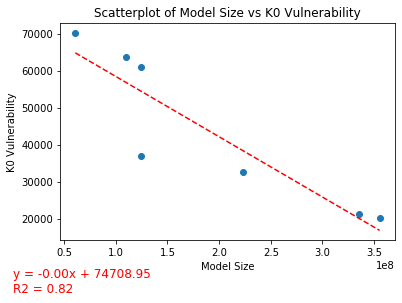

In [296]:
from scipy import stats

# Create the scatterplot
x = np.asarray([get_size(model) for model, value in vulnerability_scores])
y = np.asarray([value for _, value in vulnerability_scores])
plt.scatter(x, y, marker='o')

# Customize the plot
plt.title('Scatterplot of Model Size vs K0 Vulnerability')
plt.xlabel('Model Size')
plt.ylabel('K0 Vulnerability')

# Perform linear regression to get the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate the R-squared value
r_squared = r_value ** 2

# Label the line with the equation and R-squared value
equation = f'y = {slope:.2f}x + {intercept:.2f}\nR2 = {r_squared:.2f}'
plt.text(0.5, 3, equation, fontsize=12, color='r')

# Plot the line of best fit
x_line = np.linspace(min(x), max(x))
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='r', linestyle='--')

plt.savefig('size_vs_k0.pdf')

### correlation matrix between all models

In [260]:
from scipy.stats import pointbiserialr

correlation_matrix = np.zeros((7,7))
p_value_matrix = np.zeros((7,7))

for i in range(7):
    for j in range(7):
        # Calculate the point-biserial correlation coefficient
        correlation, p_value = pointbiserialr(X[i], X[j])
        
        correlation_matrix[i][j] = correlation
        p_value_matrix[i][j] = p_value

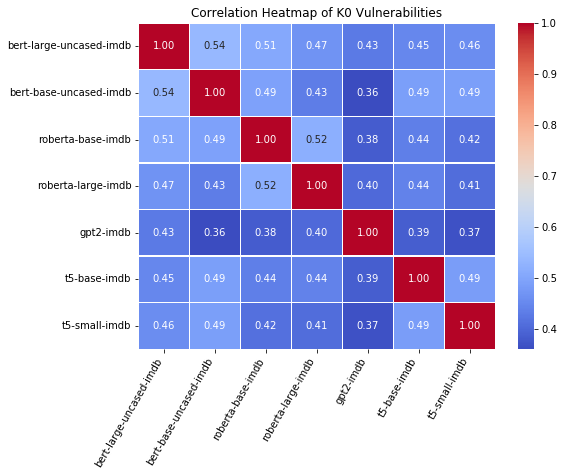

In [301]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set row and column labels
heatmap.set_xticklabels(MODELS, rotation=60, ha='right')
heatmap.set_yticklabels(MODELS, rotation=0)

plt.title("Correlation Heatmap of K0 Vulnerabilities")
plt.savefig('k0_vulnerabilities_correlation_heatmap.pdf')

All correlations seem to be positive...

Min correlation is 0.36